# **DOMAIN´S CLUSTERING**

- In this notebook I´m going to try and test different clustering models, preprocessing the data in different ways to compare and choose the best results, that is, to find different clusters with similar charasteristics or properties, with the objective of make the advertiser decision of where are the optimal domains to invest easier

In [13]:
#IMPORTING LIBRARIES

#MAIN LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#DATA TRANSFORMATION
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, Normalizer
from sklearn.decomposition import PCA

#CLUSTERING ALGORITHMS
from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.model_selection import GridSearchCV

#INTERNAL VALIDATIONS
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
#! pip install pyclustertend
from pyclustertend import ivat

#FINAL VISUALIZATIONS
import altair as alt


pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format



In [14]:
groupby_domains = pd.read_csv('DATA/Groupby Domains.csv') # Charging the main dataframe
groupby_domains.head(5)

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category,Category importance,Country,Geographical zone,Geographical zone importance
0,memurlar.net,2739246.93,8942.44,0.60,83.80,92.72,1.59,46.82,0.46,Health & Wellness,2.08,Turkey,West Europe,11.98
1,missyusa.com,1732798.15,124798.83,10.81,78.07,98.47,1.71,98.44,0.07,News & Portals,58.61,United States,North America,8.32
2,bitbol.la,1054934.05,34032.09,3.77,86.47,89.51,1.44,145.27,0.39,Sports,7.63,Peru,South America,53.27
3,youm7.com,992087.95,11080.76,1.14,61.26,91.52,1.73,48.46,0.40,News & Portals,58.61,Egypt,Africa,1.10
4,chinatimes.com,990576.14,188611.01,19.54,90.05,99.14,1.80,1311.98,0.79,News & Portals,58.61,Taiwan,Asia,13.09


In [32]:
groupby_domains.describe()

,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
count,901.00,901.00,901.00,901.00,901.00,901.00,901.00,901.00,901.00,901.00
mean,121436.16,10761.80,10.20,73.12,83.73,1.49,65.11,0.55,31.78,33.35
std,181753.64,21218.25,10.91,17.99,19.37,0.35,163.86,0.39,27.35,21.38
min,20050.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.22
25%,33495.42,1573.19,2.76,67.38,77.89,1.42,6.46,0.27,3.57,11.98
50%,60300.89,4347.56,6.84,79.08,92.11,1.58,20.90,0.49,58.61,53.27
75%,128448.64,11776.85,14.25,85.38,96.76,1.69,66.97,0.76,58.61,53.27
max,2739246.93,224538.68,112.28,100.00,100.00,2.53,3274.48,3.86,58.61,53.27


**We see that most of features didn´t follow a normal distribution. Let´s make a kernel density estimate plot for different data transformations. KDE represents the data using a continuous probability density curve. I´ll choose the some variables with high standard deviation to plot.**

In [44]:
# Features with higher standard deviation
features = groupby_domains[['Format Loads', 'Impressions','Format Fill Rate','Category importance','Geographical zone importance', 'Clicks']]

# Columns of the selected features
col_names = list(features.columns)

# Let´s preproccess the data in three different ways
minmax_scaler = MinMaxScaler()
standard_scaler=StandardScaler()
normalizer = Normalizer()

features_minmax = minmax_scaler.fit_transform(features)
features_standard = standard_scaler.fit_transform(features)
features_normalizer = normalizer.fit_transform(features)


# We create one dataframe for each transformation
features_minmax_final = pd.DataFrame(features_minmax, columns=col_names)
features_standard_final = pd.DataFrame(features_standard, columns=col_names)
features_normalizer_final = pd.DataFrame(features_normalizer, columns=col_names)


<AxesSubplot:title={'center':'Original data'}>

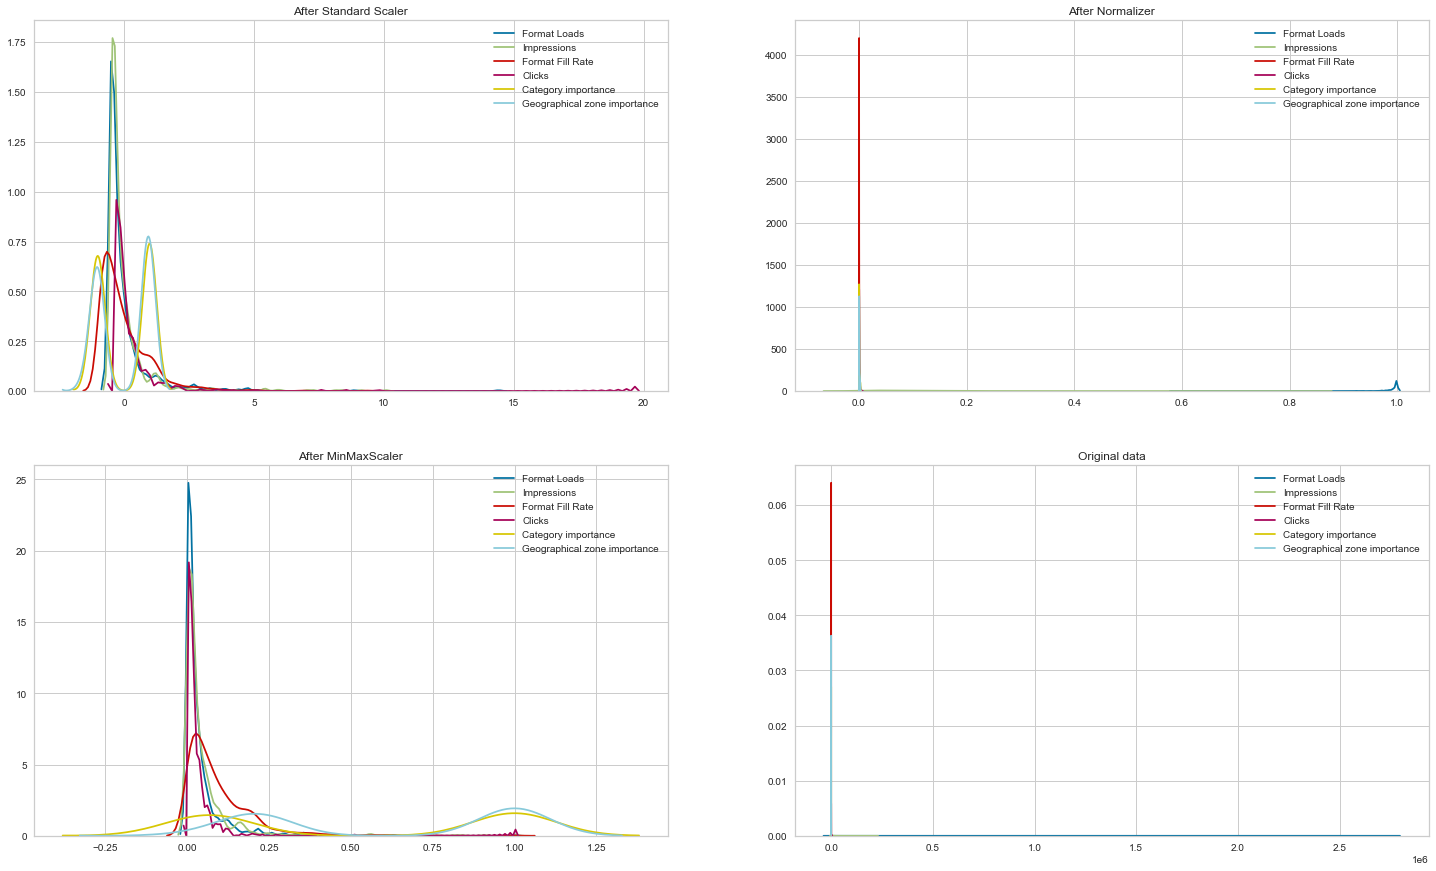

In [45]:
#Plotting the KDE features for each data transformation

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
ax1.set_title('After Standard Scaler')
sns.kdeplot(features_standard_final['Format Loads'], ax=ax1)
sns.kdeplot(features_standard_final['Impressions'], ax=ax1)
sns.kdeplot(features_standard_final['Format Fill Rate'], ax=ax1)
sns.kdeplot(features_standard_final['Clicks'], ax=ax1)
sns.kdeplot(features_standard_final['Category importance'], ax=ax1)
sns.kdeplot(features_standard_final['Geographical zone importance'], ax=ax1)

ax2.set_title('After Normalizer')
sns.kdeplot(features_normalizer_final['Format Loads'], ax=ax2)
sns.kdeplot(features_normalizer_final['Impressions'], ax=ax2)
sns.kdeplot(features_normalizer_final['Format Fill Rate'], ax=ax2)
sns.kdeplot(features_normalizer_final['Clicks'], ax=ax2)
sns.kdeplot(features_normalizer_final['Category importance'], ax=ax2)
sns.kdeplot(features_normalizer_final['Geographical zone importance'], ax=ax2)

ax3.set_title('After MinMaxScaler')
sns.kdeplot(features_minmax_final['Format Loads'], ax=ax3)
sns.kdeplot(features_minmax_final['Impressions'], ax=ax3)
sns.kdeplot(features_minmax_final['Format Fill Rate'], ax=ax3)
sns.kdeplot(features_minmax_final['Clicks'], ax=ax3)
sns.kdeplot(features_minmax_final['Category importance'], ax=ax3)
sns.kdeplot(features_minmax_final['Geographical zone importance'], ax=ax3)

ax4.set_title('Original data')
sns.kdeplot(features['Format Loads'], ax=ax4)
sns.kdeplot(features['Impressions'], ax=ax4)
sns.kdeplot(features['Format Fill Rate'], ax=ax4)
sns.kdeplot(features['Clicks'], ax=ax4)
sns.kdeplot(features['Category importance'], ax=ax4)
sns.kdeplot(features['Geographical zone importance'], ax=ax4)



As we saw in the feature analysis, the points of each feature are very concentrated

#### IMPORTANT: 
**The proccess that is detailed below has been done with different combinations of variables**.

- First I considered all the variables at once, applying different data preproccesings 
- Second I tested the clustering algorithms several times selecting different combinations of variables, between 6 and 9
- Finally I did that comes next, wich has turned out to be the best choice

**Categorical variables issue**:

- Categories and Geographical zone variables are, from a business point of view, two of the most important variables because between the requirementes that the advertiser ask for in a new campaign, always are the categories and the region where it has to be deployed.
- I tried some clustering models that accept mixed data, i.e KPrototypes, but the results were confused and the cluster were not well defined.
- That´s why I finally created the Category importance and Geographical zone importance columns, so the categories and regions could be representated in the model as the relative importance that each region/category has over the total traffic.

****In order to get a better clustering performance, I´m gonna drop the following columns :****

- **Domain:** it´s a string and doesn´t add nothing to the model
- **Category:** It´s already represented in the Category importance column.
- **Viewability Rate, Efficiency Rate:** these columns are important to the advertisers (that´s the reason I didn´t drop them in the first place) but both of them have really high percentages for most of Domains, so they are not useful to find differences between them
- **Clicks**: It has a strong correlation with the Impressions variable, and it´s represented in the CTR (Clicks/Impressions)
- **Country** : I consider these categorical variable can´t add anything interesting to the model.
- **Geographical zone:** It´s already represented in the Geographical zone importance column.
- **'Format Loads', 'Impressions'**: ***After repeating this whole proccess with different variables, I decided to keep for this first clustering only the variables represented by percentages, in order to have the date with similar scales. It has proven that if I take the Format Loads and Impressions variable, the models are distorted because of it´s large scale, although I applied transformation to the data as MinMax, Standard or Robust scalers***

In [4]:
groupby_domains_clustering = groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks','Category', 'Country',
                                                   'Viewability Rate', 'Efficiency Rate', 'Geographical zone'], 1)

<AxesSubplot:>

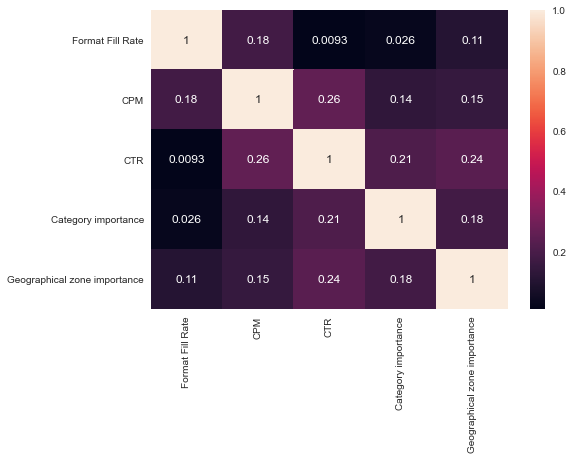

In [5]:
sns.heatmap(groupby_domains_clustering.corr(), annot=True)

- **I keep 5 variables for this clustering fase. The correlation between them is not strong, there is no correlations above 30%**

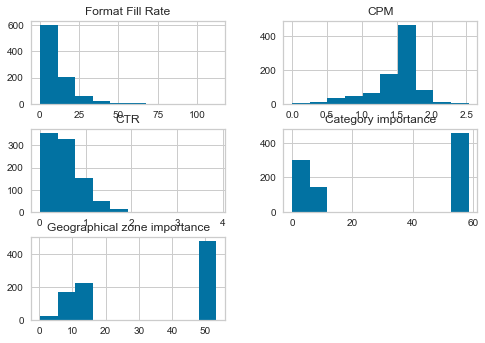

In [7]:
groupby_domains_clustering.hist();

I´m gonna test the clustering over three different data transformations :

- **Standarizing the data with Standard Scaler**
- **Normalizing samples individually to unit norm.**
- **Transforming features by scaling each feature to a given range (0,1) with MinMax Scaler**

In [5]:
StandardScaler_data = pd.DataFrame(StandardScaler().fit_transform(groupby_domains_clustering))
Normalization_data = pd.DataFrame(Normalizer(norm='l2').fit_transform(groupby_domains_clustering))
Minmax_data = pd.DataFrame(MinMaxScaler().fit_transform(groupby_domains_clustering))

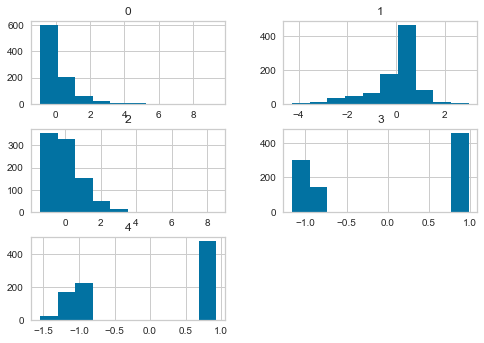

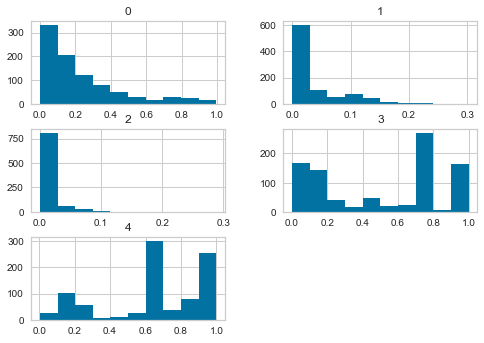

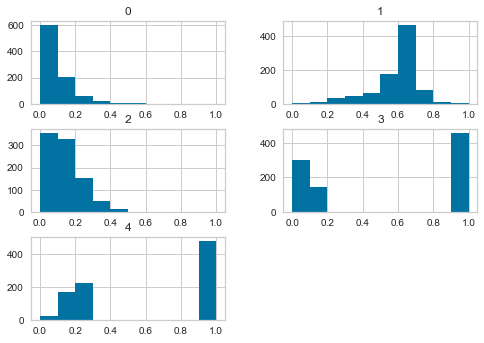

In [15]:
StandardScaler_data.hist(); Normalization_data.hist(); Minmax_data.hist();

### Visual Assessment of cluster Tendency (VAT)

This visualisation can be useful to obtain an insight on the number of cluster and cluster hierarchy. The more the color is black, the more the distance between two observations is small. A way to interpert the image is to count the number of black square in the diagonal which should represent the number of cluster.



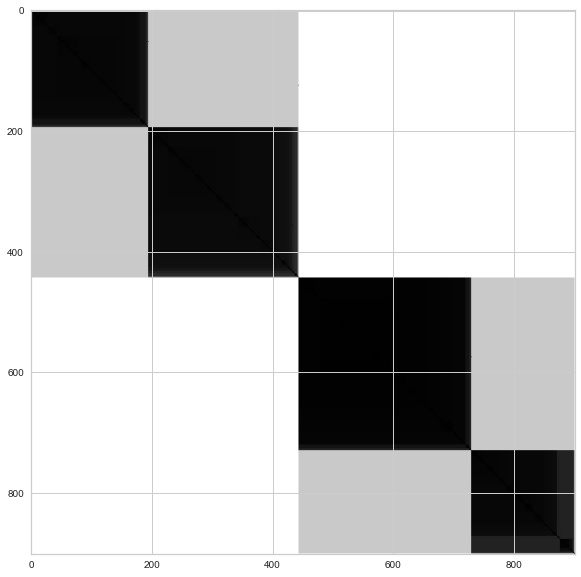

In [10]:
ivat(groupby_domains_clustering)

- According to this, the optimal number of cluster could be four

# ***KMEANS***

I´m going to start with the most common clustering algorithm

#### Applying GRIDSEARCHCV to find the best parameters for the KMeans algorithm

- **With the Standard Scaler transformation:**

In [17]:
kmeans = KMeans()
parameters = {'n_clusters':range(2,8),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20],
              'max_iter' : [100,200,300,500,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_standardscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [18]:
%%time
gridsearchcv_standardscaler.fit(StandardScaler_data)

Wall time: 26min 17s


GridSearchCV(estimator=KMeans(),
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [100, 200, 300, 500, 700, 1000],
                         'n_clusters': range(2, 8), 'n_init': [5, 10, 15, 20]})

In [52]:
#Saving the results in a DataFrame
gridsearch_results_SS = pd.DataFrame(gridsearchcv_standardscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_SS.to_csv('GridSearch Kmeans - Standard Scaler Results.csv')
gridsearch_results_SS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
404,0.31,0.02,0.01,0.01,full,k-means++,700,7,5,"{'algorithm': 'full', 'init': 'k-means++', 'ma...",-285.24,-283.80,-295.44,-419.37,-372.91,-331.35,55.05,1
238,0.15,0.01,0.01,0.01,auto,random,500,7,15,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-283.56,-285.63,-295.01,-419.69,-372.91,-331.36,55.18,2
500,0.32,0.01,0.00,0.00,full,random,300,7,5,"{'algorithm': 'full', 'init': 'random', 'max_i...",-285.11,-285.04,-294.26,-419.37,-373.06,-331.37,55.04,3


In [47]:
gridsearchcv_standardscaler.best_estimator_

KMeans(algorithm='full', max_iter=700, n_clusters=7, n_init=5)

-  **With the MinMax Scaler transformation:**

In [26]:
kmeans = KMeans()
parameters = {'n_clusters':range(2,8),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [100,200,300,500,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_minmaxscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [27]:
%%time
gridsearchcv_minmaxscaler.fit(Minmax_data)

Wall time: 35min 12s


GridSearchCV(estimator=KMeans(),
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [100, 200, 300, 500, 700, 1000],
                         'n_clusters': range(2, 8),
                         'n_init': [5, 10, 15, 20, 25]})

In [35]:
#Saving the results in a DataFrame
gridsearch_results_MM = pd.DataFrame(gridsearchcv_minmaxscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_MM.to_csv('DATA/GridSearch Results with MinMax Scaler.csv')
gridsearch_results_MM.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
115,0.06,0.01,0.00,0.00,auto,k-means++,500,7,5,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",-4.37,-4.06,-4.02,-6.51,-6.28,-5.05,1.11,1
866,0.13,0.01,0.00,0.00,elkan,k-means++,700,7,10,"{'algorithm': 'elkan', 'init': 'k-means++', 'm...",-4.37,-4.06,-4.10,-6.52,-6.28,-5.06,1.10,2
775,0.06,0.01,0.00,0.00,elkan,k-means++,200,7,5,"{'algorithm': 'elkan', 'init': 'k-means++', 'm...",-4.37,-4.06,-4.11,-6.51,-6.27,-5.07,1.09,3


In [51]:
gridsearchcv_minmaxscaler.best_estimator_

KMeans(max_iter=500, n_clusters=7, n_init=5)

** By using the K-Means++ algorithm, we optimize the step where we randomly pick the cluster centroid, and we are more likely to find a solution that is competitive to the optimal K-Means solution while using the K-Means++ initialization**


###  VISUALIZATION TO OBTAIN THE IDEAL NUMBER OF CLUSTERS

**visualization_clusters function**
.The following function will return 3 graphs representing these 3 metrics to evaluate the number of clusters I should choose:

- **Calinski-Harabasz score:** computes the ratio of dispersion between and within clusters.
- **Silhouette score:** Compute the mean Silhouette Coefficient of all samples. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters, and negative values generally indicate that a sample has been assigned to the wrong cluster.
- **Distortion:**  computes the sum of squared distances from each point to its assigned center.

In [6]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz and silhouette scores visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)        # Fit the data to the visualizer
    visualizer2.show()        # Finalize and render the figure
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        # Fit the data to the visualizer
    visualizer3.show()        # Finalize and render the figure

- ***KMeans - Standard Scaler Data visualization:***

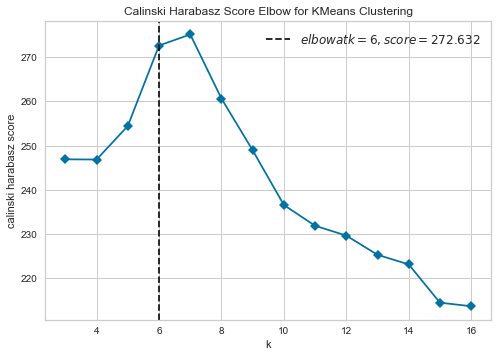

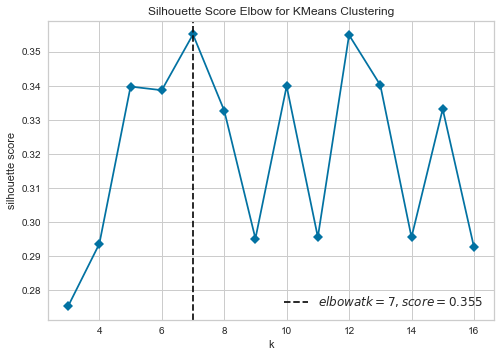

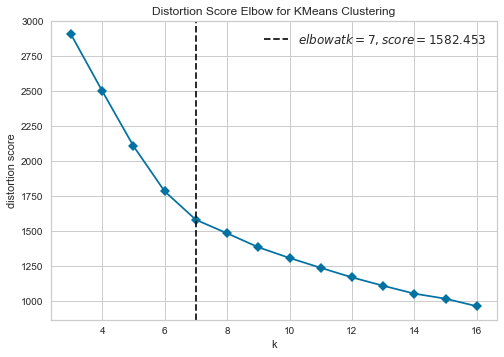

In [123]:
#With the hiperparameters of GridSearchCV
model = KMeans(init='k-means++', max_iter=700, n_init=5, algorithm='full')
visualization_clusters(StandardScaler_data, model)

-  ***KMeans - MinMax Scaler Data visualization:***

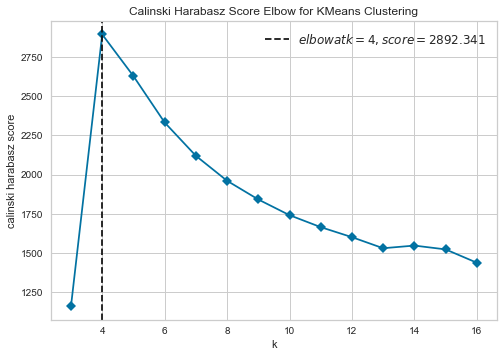

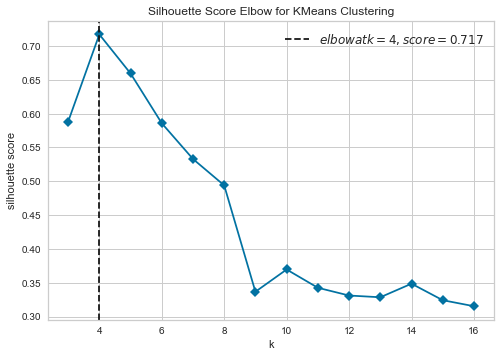

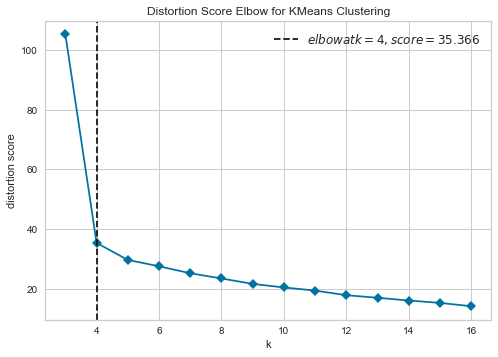

In [124]:
#With the hiperparameters of GridSearchCV
model = KMeans(init='k-means++', max_iter=500, n_init=5, algorithm='auto')
visualization_clusters(Minmax_data, model)

- ***KMeans - Normalizer Data visualization:***

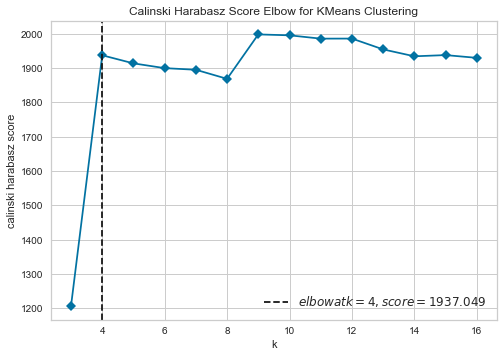

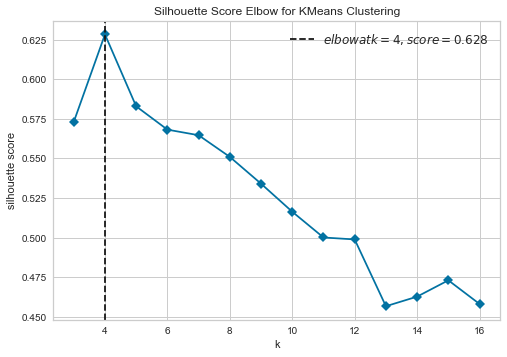

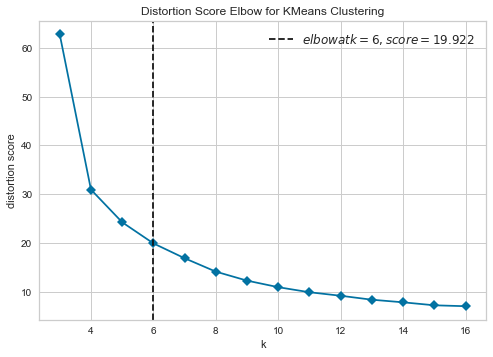

In [57]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(Normalization_data, model)

- ***KMeans - Raw Data visualization:***


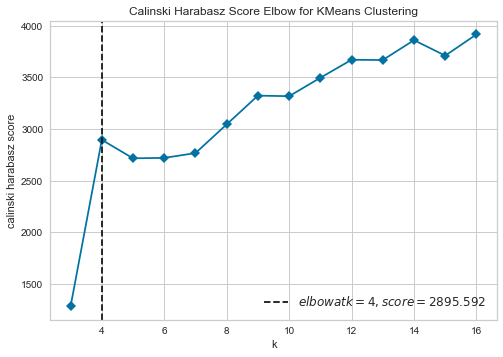

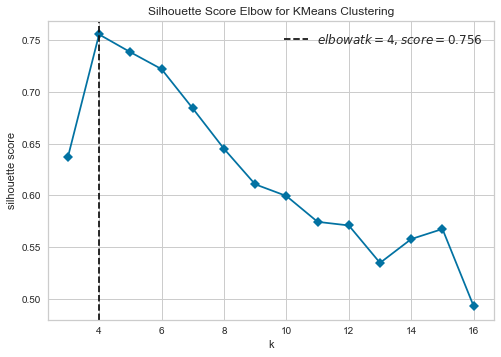

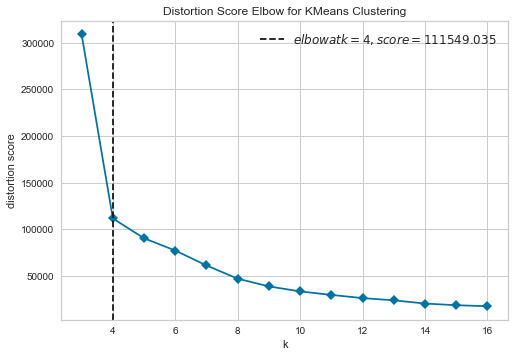

In [27]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_clustering, model)

### TRAINING THE KMEANS MODEL

**results_evaluation function**:
- I´ll use the next function to evaluate the results with two internal validation metrics that I specified before. I´ll add the **Davies Bouldin Score**: The score is defined as the average similarity measure of each cluster with its most similar cluster. The minimum score is zero, with lower values indicating better clustering.
- It will return the main characterisctics of each cluster


In [7]:
def results_evaluation(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))

- **With the Standard Scaler Data**

CLUSTERING DIVISION:
 0    284
1    182
4    157
3    121
5    108
2     49
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,136400.25,9963.17,9.08,78.22,88.74,1.59,53.84,0.50,58.61,35.67
1,121882.71,6670.65,6.93,75.62,88.80,1.60,26.58,0.41,3.81,11.04
2,132107.53,43513.01,41.92,79.04,93.78,1.66,175.40,0.42,34.27,36.16
3,130279.70,12531.35,8.97,84.39,91.83,1.62,148.66,1.18,53.20,45.18
4,110760.55,9636.43,11.08,76.15,87.86,1.56,57.47,0.56,4.39,53.27
5,82103.12,4550.32,4.39,35.73,42.40,0.72,27.14,0.24,23.08,21.35


The Silhouette Score is:  0.276483507190948
The Calinski Harabasz Score is:  244.4912745874891
The Davies Douldin Score is:  1.2135056913816158


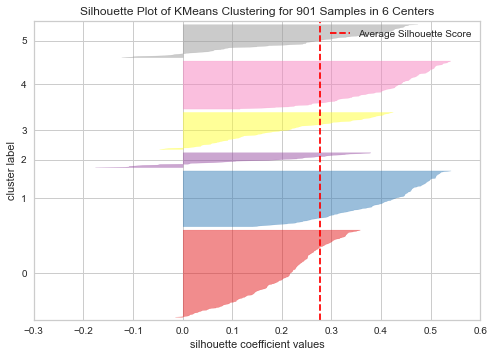

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 901 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [74]:
kmeans_StandardScaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_StandardScaler.fit(StandardScaler_data)
results_evaluation(kmeans_StandardScaler, StandardScaler_data)
    

#SilhouetteVisualizer returns a plot with the Silhouette scores visualization, where we can see the estructure of the clusters.
sv = SilhouetteVisualizer(kmeans_StandardScaler)
sv.fit(StandardScaler_data)
sv.show()


- **With the MinMax Scaler Data**

CLUSTERING DIVISION:
 1    286
0    249
2    194
3    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,3.81,10.95
1,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,58.61,53.27
2,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,4.36,53.27
3,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,58.61,10.18


The Silhouette Score is:  0.7171556372743594
The Calinski Harabasz Score is:  2892.341465442794
The Davies Douldin Score is:  0.42723166080963476


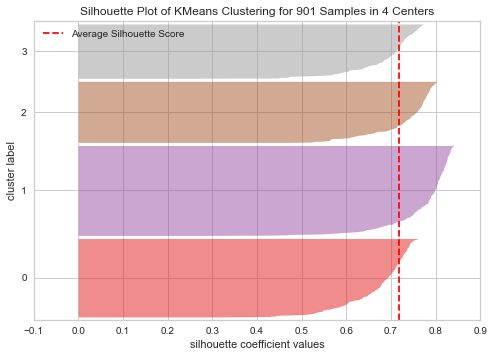

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 901 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [167]:
kmeans_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_minmax.fit(Minmax_data)
results_evaluation(kmeans_minmax, Minmax_data)

sv = SilhouetteVisualizer(kmeans_minmax)
sv.fit(Minmax_data)
sv.show()


- **With the Normalizer Data**

CLUSTERING DIVISION:
 1    338
0    284
2    173
3    106
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,108932.62,7296.45,7.99,69.94,81.05,1.44,45.79,0.51,3.55,38.61
1,120468.33,10496.15,9.14,75.90,84.68,1.53,74.84,0.64,50.47,46.63
2,151212.13,11562.16,9.54,72.53,83.60,1.47,69.78,0.52,58.01,10.09
3,109425.65,19587.20,20.58,73.69,88.12,1.53,78.22,0.42,5.02,14.87


The Silhouette Score is:  0.6283270653397992
The Calinski Harabasz Score is:  1937.0493873897265
The Davies Douldin Score is:  0.5621446847026121


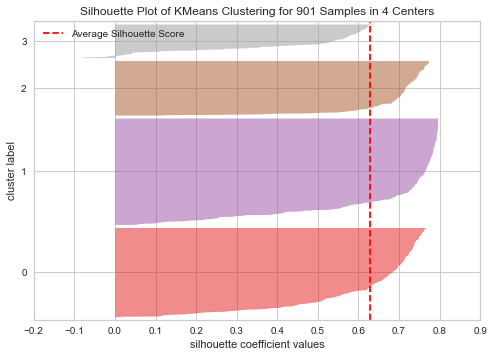

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 901 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [76]:
kmeans_normalization = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_normalization.fit(Normalization_data)
results_evaluation(kmeans_normalization, Normalization_data)


sv = SilhouetteVisualizer(kmeans_normalization)
sv.fit(Normalization_data)
sv.show()


- **With the raw data**

CLUSTERING DIVISION:
 2    286
0    249
3    194
1    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,3.81,10.95
1,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,58.61,10.18
2,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,58.61,53.27
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,4.36,53.27


The Silhouette Score is:  0.7557272728843112
The Calinski Harabasz Score is:  2895.5916125736658
The Davies Douldin Score is:  0.390265901336067


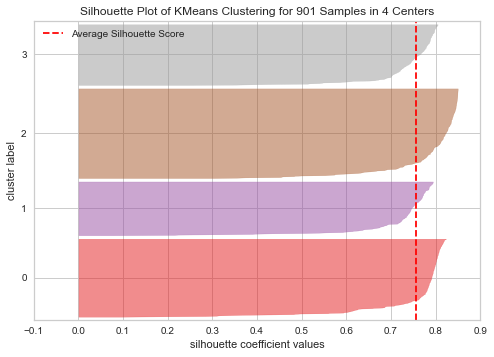

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 901 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [77]:
kmeans_raw = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_raw.fit(groupby_domains_clustering)
results_evaluation(kmeans_raw, groupby_domains_clustering)

sv = SilhouetteVisualizer(kmeans_raw)
sv.fit(groupby_domains_clustering)
sv.show()

- We can see that MinMax Scaler Data has the same results that the raw data

- The best results are with MinMax scaler, where the clustering has been done over the Category and Geographical zone variables, and with Normalization, where the main variable to divide the data has been the Format Fill Rate

# ***HIERARCHICAL CLUSTERING***

- Plotting the dendogram for each data

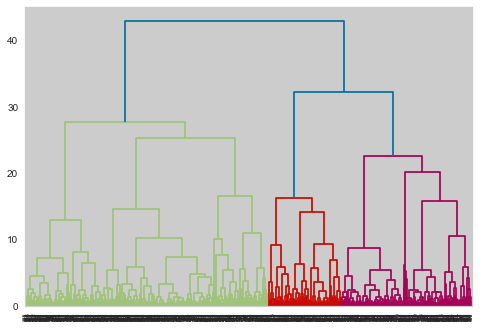

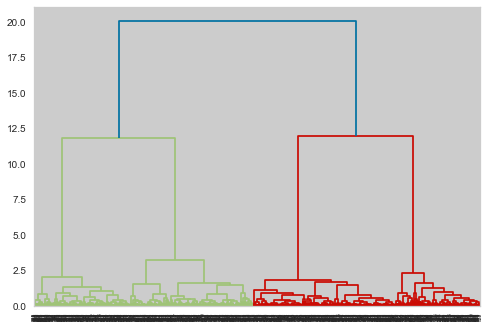

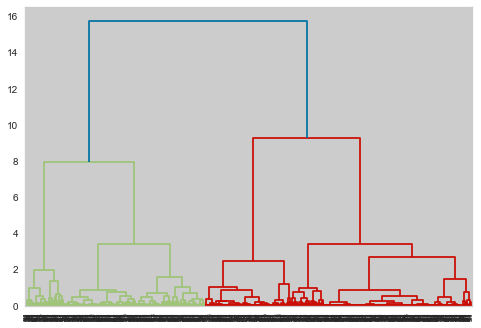

In [69]:
for data in [StandardScaler_data,Minmax_data,Normalization_data]:
    Z = linkage(data, 'ward')
    dendrogram(Z)
    plt.show()

- **With the Standard Scaler Data**

In [70]:
cut_distance = 20
clusters_hc = fcluster(linkage(StandardScaler_data, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([154, 227, 110, 146, 126,   8, 130], dtype=int64))

In [81]:
cluster = AgglomerativeClustering(n_clusters=7)  
cluster.fit(StandardScaler_data)
results_evaluation(cluster, StandardScaler_data)

CLUSTERING DIVISION:
 4    227
3    154
2    146
1    130
5    126
0    110
6      8
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,134006.89,11131.23,7.21,82.10,91.22,1.58,138.88,1.22,40.22,30.26
1,153334.73,13578.37,13.70,78.13,91.11,1.62,58.33,0.43,47.87,10.76
2,82084.16,5365.45,5.82,41.79,49.86,0.86,27.16,0.26,22.22,23.67
3,123588.00,14354.75,12.97,78.33,90.56,1.61,72.49,0.58,4.50,53.27
4,118896.69,11400.23,11.29,80.55,89.78,1.62,68.07,0.60,58.61,53.27
5,127007.98,5234.41,5.17,75.76,88.72,1.62,17.76,0.29,3.53,11.17
6,91289.01,58173.35,69.49,86.75,97.23,1.75,373.15,0.65,37.96,20.01


The Silhouette Score is:  0.27512563931979195
The Calinski Harabasz Score is:  204.0303371479628
The Davies Douldin Score is:  1.1944254553706788


- **With the MinMax Scaler Data**


In [82]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 5
clusters_hc = fcluster(linkage(Minmax_data, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([194, 249, 286, 172], dtype=int64))

In [83]:
clusters = AgglomerativeClustering(n_clusters=4)  
clusters.fit(Minmax_data)
results_evaluation(clusters, Minmax_data)

CLUSTERING DIVISION:
 2    286
0    249
3    194
1    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,3.81,10.95
1,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,58.61,10.18
2,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,58.61,53.27
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,4.36,53.27


The Silhouette Score is:  0.7171556372743594
The Calinski Harabasz Score is:  2892.3414654427947
The Davies Douldin Score is:  0.4272316608096348


- **With the Normalizer Data**

In [84]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 5
clusters_hc = fcluster(linkage(Normalization_data, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([ 78, 285, 173, 365], dtype=int64))

In [86]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(Normalization_data)
results_evaluation(cluster, Normalization_data)

CLUSTERING DIVISION:
 1    365
0    285
2    173
3     78
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,109182.83,8842.74,8.84,70.40,81.69,1.45,51.74,0.50,3.50,39.27
1,118544.57,10070.72,8.88,75.42,84.36,1.52,71.47,0.63,47.27,44.13
2,151212.13,11562.16,9.54,72.53,83.60,1.47,69.78,0.52,58.01,10.09
3,113697.49,19232.54,22.80,73.56,88.56,1.53,73.86,0.44,4.45,12.85


The Silhouette Score is:  0.6140284243532858
The Calinski Harabasz Score is:  1780.5298035861003
The Davies Douldin Score is:  0.5272804717895082


- **The results are very similar to the kmeans algorithm**

# ***DBSCAN***

- Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. 

- First, I´m going to find the optimal value of eps, the value for which two points are considered neighbors if the distance between the two points is below the threshold epsilon.

- **With the Standard Scaler Data**

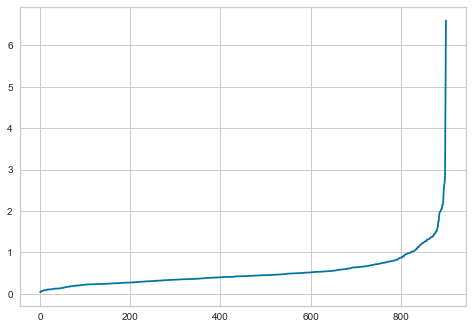

In [87]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(p=1)
nbrs = neigh.fit(StandardScaler_data)
distances, indices = nbrs.kneighbors(StandardScaler_data)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [94]:
dbs = DBSCAN(eps=1, min_samples=5)
dbs = dbs.fit(StandardScaler_data)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 5 clusters


(array([-1,  0,  1,  2,  3], dtype=int64),
 array([ 39, 236, 162, 187, 277], dtype=int64))

In [95]:
results_evaluation(dbs,StandardScaler_data)

CLUSTERING DIVISION:
  3    277
 0    236
 2    187
 1    162
-1     39
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
-1,91701.32,22217.99,28.78,70.60,78.72,1.53,132.32,0.86,30.38,27.57
0,111729.60,6069.77,6.70,67.22,79.00,1.41,26.14,0.37,3.83,10.97
1,153877.58,10203.47,8.29,72.44,83.61,1.47,62.88,0.50,58.61,10.28
2,108578.62,12780.62,12.04,72.30,84.23,1.48,68.50,0.55,4.37,53.27
3,123599.53,12110.04,10.45,79.44,88.20,1.58,87.86,0.69,58.61,53.27


The Silhouette Score is:  0.31316169679436334
The Calinski Harabasz Score is:  179.50792505201187
The Davies Douldin Score is:  2.0716473310781907


- **With the MinMax Scaler Data**


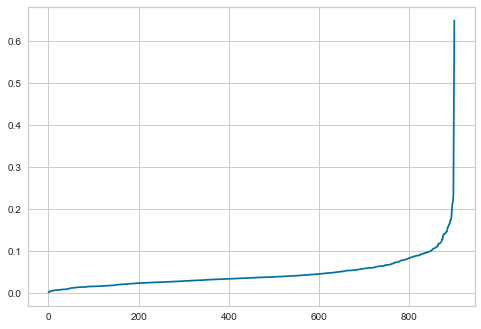

In [96]:
neigh = NearestNeighbors()
nbrs = neigh.fit(Minmax_data)
distances, indices = nbrs.kneighbors(Minmax_data)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [103]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.15, min_samples=5)
dbs = dbs.fit(Minmax_data)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 5 clusters


(array([-1,  0,  1,  2,  3], dtype=int64),
 array([ 29, 239, 165, 188, 280], dtype=int64))

In [104]:
results_evaluation(dbs, Minmax_data )

CLUSTERING DIVISION:
  3    280
 0    239
 2    188
 1    165
-1     29
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
-1,105902.13,22413.75,28.28,71.94,79.98,1.62,146.79,0.98,28.33,27.13
0,110854.05,6452.83,7.14,67.41,79.11,1.41,26.42,0.37,3.82,11.04
1,151879.61,10417.75,8.93,72.60,83.75,1.47,62.75,0.50,58.61,10.24
2,108713.60,12835.97,12.07,72.36,84.28,1.48,70.97,0.55,4.37,53.27
3,122680.02,12043.10,10.44,78.92,87.69,1.57,87.14,0.68,58.61,53.27


The Silhouette Score is:  0.6912105139278503
The Calinski Harabasz Score is:  1640.7721734234112
The Davies Douldin Score is:  1.4330848749166183


- **With the Normalizer Data**

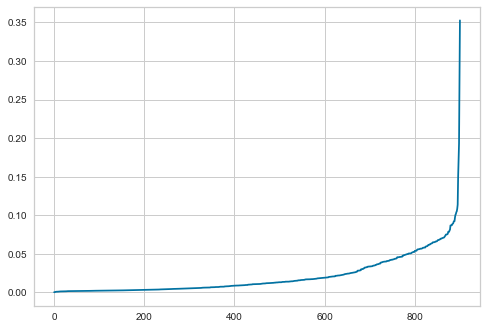

In [105]:
neigh = NearestNeighbors()
nbrs = neigh.fit(Normalization_data)
distances, indices = nbrs.kneighbors(Normalization_data)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [112]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.1, min_samples=5)
dbs = dbs.fit(Normalization_data)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 6 clusters


(array([-1,  0,  1,  2,  3,  4], dtype=int64),
 array([ 21, 425, 143,  21, 286,   5], dtype=int64))

In [113]:
results_evaluation(dbs, Normalization_data )

CLUSTERING DIVISION:
  0    425
 3    286
 1    143
-1     21
 2     21
 4      5
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
-1,107673.08,20126.03,19.24,74.65,83.03,1.59,118.89,0.68,14.85,7.79
0,111317.99,9720.72,9.98,69.58,81.47,1.44,49.80,0.46,4.02,30.40
1,145132.00,10661.11,8.70,72.91,84.18,1.48,66.07,0.53,58.61,11.62
2,204997.61,3660.99,3.42,70.47,80.83,1.44,23.31,0.54,58.61,1.23
3,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,58.61,53.27
4,40428.18,24447.74,39.96,61.30,70.24,1.32,37.94,0.23,48.21,7.70


The Silhouette Score is:  0.4612171458901774
The Calinski Harabasz Score is:  451.7617870903881
The Davies Douldin Score is:  1.3135177833819982


# ***PCA + KMEANS***

**By reducing the number of features, the performance of our algorithm can be improved. On top of that, by decreasing the number of features the noise is also reduced.
In the case of PCA and K-means in particular, there appears to be an even closer relationship between the two.**

- **With the Standard Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

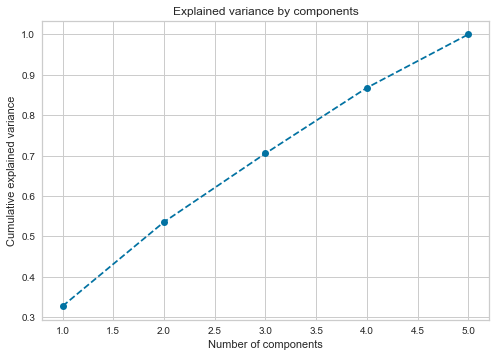

In [114]:
pca = PCA()
pca.fit(StandardScaler_data)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [116]:
#PCA transformation
pca_standardscaler = PCA(n_components=4)
pca_standardscaler = pca_standardscaler.fit_transform(StandardScaler_data)

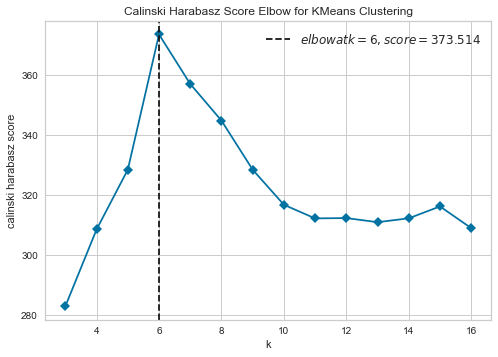

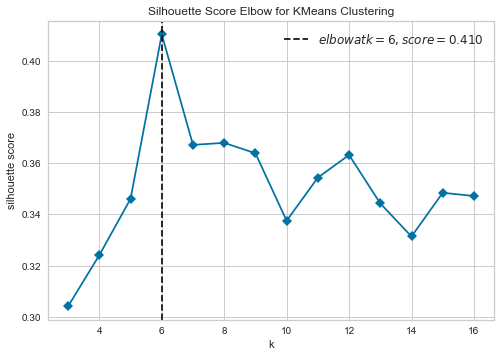

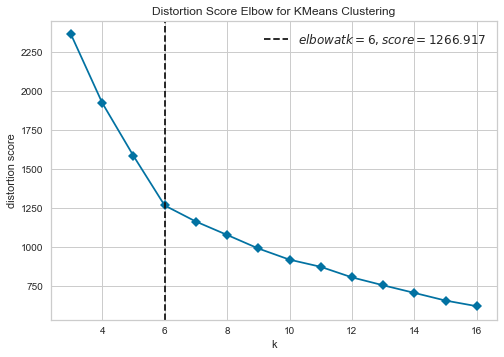

In [117]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_standardscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 5-7

In [120]:
kmeans_pca_standardscaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_standardscaler.fit(pca_standardscaler)
results_evaluation(kmeans_pca_standardscaler, pca_standardscaler)

CLUSTERING DIVISION:
 3    252
1    190
0    163
2    142
4    100
5     54
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,113783.44,10020.72,11.20,76.80,88.39,1.56,68.03,0.62,4.35,52.75
1,118966.28,6524.19,6.96,75.17,88.24,1.59,26.88,0.44,3.82,11.06
2,157388.19,10227.69,8.51,77.25,89.02,1.57,61.55,0.55,58.61,10.20
3,122452.97,10396.45,8.95,81.26,89.26,1.61,87.57,0.76,58.61,52.78
4,79004.78,4656.75,4.14,34.11,40.81,0.71,26.98,0.21,21.32,25.17
5,132517.33,42324.07,40.08,78.12,93.56,1.66,166.01,0.39,36.60,38.51


The Silhouette Score is:  0.410276685396024
The Calinski Harabasz Score is:  373.432835915388
The Davies Douldin Score is:  0.8967262878723844


- **With the MinMax Scaler Data**


Text(0, 0.5, 'Cumulative explained variance')

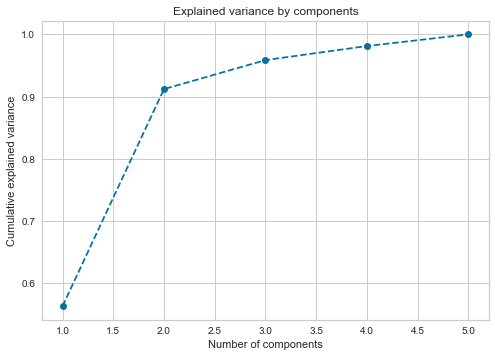

In [8]:
pca = PCA()
pca.fit(Minmax_data)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [9]:
pca_minmax = PCA(n_components=2)
pca_minmax = pca_minmax.fit_transform(Minmax_data)

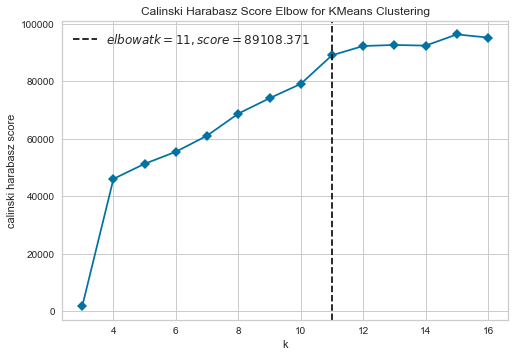

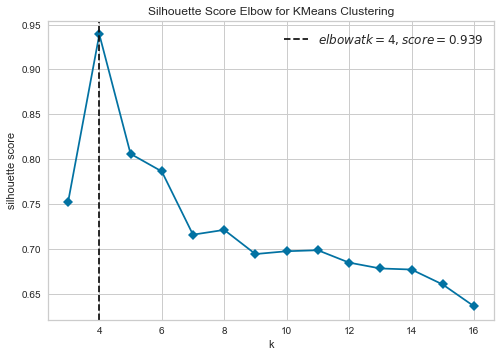

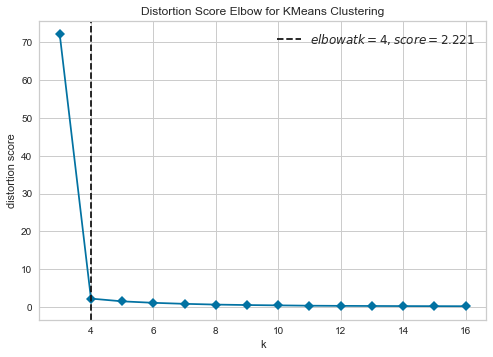

In [10]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_minmax, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

CLUSTERING DIVISION:
 1    286
0    249
2    194
3    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,3.81,10.95
1,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,58.61,53.27
2,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,4.36,53.27
3,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,58.61,10.18


The Silhouette Score is:  0.9390588867049904
The Calinski Harabasz Score is:  46054.047925255305
The Davies Douldin Score is:  0.10759213828891317


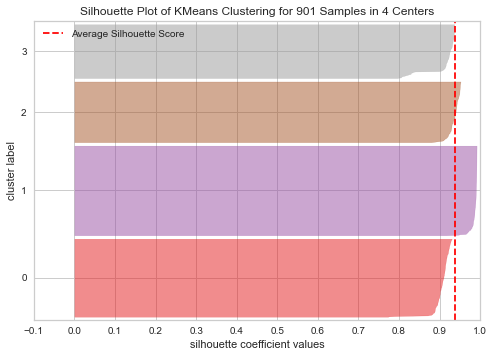

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 901 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
kmeans_pca_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

sv = SilhouetteVisualizer(kmeans_pca_minmax)
sv.fit(pca_minmax)
sv.show()

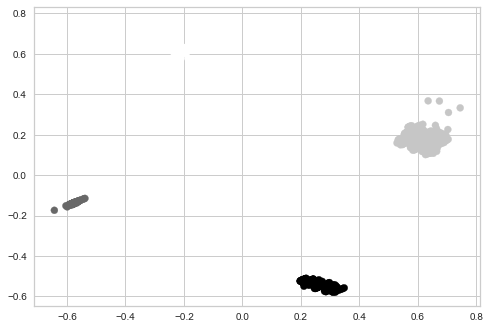

In [166]:
pca_minmax_df = pd.DataFrame(pca_minmax.copy())
pca_minmax_df['Cluster'] = kmeans_pca_minmax.labels_
plt.scatter(pca_minmax_df[0], pca_minmax_df[1], c=pca_minmax_df['Cluster'] )

- **With the Normalizer Data**

Text(0, 0.5, 'Cumulative explained variance')

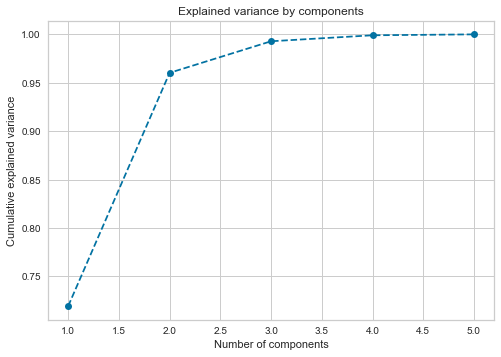

In [128]:
pca = PCA()
pca.fit(Normalization_data)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [130]:
pca_normalization = PCA(n_components=2)
pca_normalization = pca_normalization.fit_transform(Normalization_data)

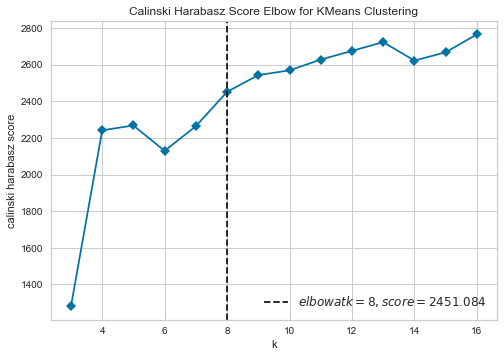

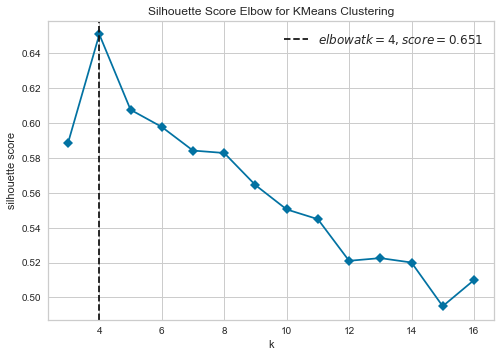

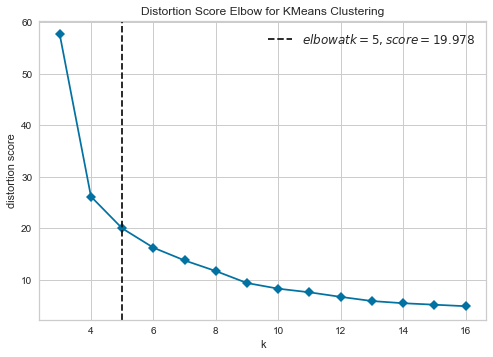

In [131]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_normalization, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [143]:
kmeans_pca_normalization = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_normalization.fit(pca_normalization)
results_evaluation(kmeans_pca_normalization, pca_normalization)

CLUSTERING DIVISION:
 1    332
0    304
2    173
3     92
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,109922.96,7955.95,8.13,69.93,81.18,1.44,48.42,0.50,3.61,37.24
1,119636.58,10548.16,9.25,76.17,84.87,1.53,75.48,0.64,51.27,47.25
2,151212.13,11562.16,9.54,72.53,83.60,1.47,69.78,0.52,58.01,10.09
3,109982.13,19299.29,21.75,73.71,88.31,1.54,74.09,0.42,5.19,14.05


The Silhouette Score is:  0.6505662616020933
The Calinski Harabasz Score is:  2241.141904889534
The Davies Douldin Score is:  0.5015574653853165


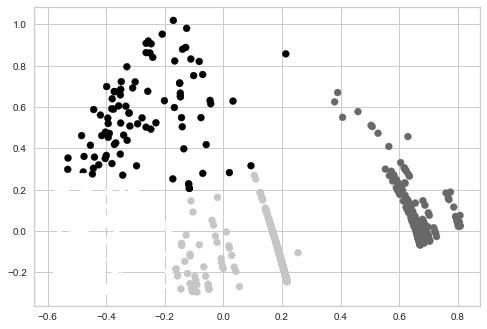

In [155]:
pca_norm_df = pd.DataFrame(pca_normalization.copy())
pca_norm_df['Cluster'] = kmeans_pca_normalization.labels_
plt.scatter(pca_norm_df[0], pca_norm_df[1], c=pca_norm_df['Cluster'])

# *TESTS RESULTS*

<img src="Graphs/RESULTS CLUSTERING TESTS.jpg">

- ***I´ll work with the clustering with the best Silhouette score and Calinski Harabasz Score, wich definitely is THE KMEANS+PCA with  MinMax Scaler***

In [41]:
kmeans_pca_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=500, n_init=5, algorithm='auto')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 1    286
2    249
3    194
0    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category importance,Geographical zone importance
Cluster,,,,,,,,,,
0,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,58.61,10.18
1,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,58.61,53.27
2,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,3.81,10.95
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,4.36,53.27


The Silhouette Score is:  0.9390588867049904
The Calinski Harabasz Score is:  46054.0479252553
The Davies Douldin Score is:  0.10759213828891316


In [42]:
#Creating 1 dataframe from each cluster

clusters = groupby_domains_clustering.copy()
clusters['Cluster'] = kmeans_pca_minmax.labels_
clusters['Geographical zone'] = groupby_domains['Geographical zone'].copy()
clusters['Country'] = groupby_domains['Country'].copy()
clusters['Category'] = groupby_domains['Category'].copy()
clusters['Cluster'] = clusters['Cluster'] + 1

cluster1 = clusters[clusters['Cluster']==1]
cluster2 = clusters[clusters['Cluster']==2]
cluster3 = clusters[clusters['Cluster']==3]
cluster4 = clusters[clusters['Cluster']==4]


clusters.groupby('Cluster').mean()

,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance
Cluster,,,,,
1,10.21,1.48,0.53,58.61,10.18
2,10.59,1.57,0.69,58.61,53.27
3,8.07,1.41,0.39,3.81,10.95
4,12.35,1.49,0.56,4.36,53.27


In [43]:
# Displaying the main statisctics of each cluster
display(cluster1.describe(),cluster2.describe(), cluster3.describe(), cluster4.describe()) 


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,172.00,172.00,172.00,172.00,172.00,172.00
mean,10.21,1.48,0.53,58.61,10.18,1.00
std,13.37,0.36,0.37,0.00,3.76,0.00
min,0.01,0.30,0.00,58.61,0.22,1.00
25%,2.13,1.42,0.26,58.61,8.32,1.00
50%,6.18,1.59,0.45,58.61,11.98,1.00
75%,13.75,1.70,0.68,58.61,13.09,1.00
max,112.28,2.12,2.32,58.61,13.09,1.00


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,286.00,286.00,286.00,286.00,286.00,286.00
mean,10.59,1.57,0.69,58.61,53.27,2.00
std,9.35,0.26,0.39,0.00,0.00,0.00
min,0.02,0.24,0.01,58.61,53.27,2.00
25%,3.78,1.51,0.43,58.61,53.27,2.00
50%,8.00,1.62,0.65,58.61,53.27,2.00
75%,13.95,1.69,0.87,58.61,53.27,2.00
max,53.97,2.53,3.86,58.61,53.27,2.00


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,249.00,249.00,249.00,249.00,249.00,249.00
mean,8.07,1.41,0.39,3.81,10.95,3.00
std,10.63,0.44,0.37,2.52,2.12,0.00
min,0.00,0.00,0.00,0.07,1.10,3.00
25%,1.67,1.25,0.12,1.98,10.43,3.00
50%,4.53,1.54,0.29,3.57,11.98,3.00
75%,10.41,1.68,0.57,6.61,13.09,3.00
max,85.34,2.31,1.90,7.63,13.09,3.00


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,194.00,194.00,194.00,194.00,194.00,194.00
mean,12.35,1.49,0.56,4.36,53.27,4.00
std,10.57,0.31,0.35,2.42,0.00,0.00
min,0.00,0.51,0.00,0.07,53.27,4.00
25%,4.71,1.43,0.31,2.08,53.27,4.00
50%,9.42,1.56,0.50,4.76,53.27,4.00
75%,18.82,1.66,0.76,6.61,53.27,4.00
max,67.94,2.38,2.20,7.63,53.27,4.00


In [44]:
groupby_domains['Cluster'] = clusters['Cluster']
groupby_domains.to_csv('DATA/Main Clusters before subclustering.csv',index=False)


## **CLUSTER ANALYSIS AND VISUALIZATION**

***If the notebook is reproduced the specific number of the clusters detailed below will be different***

**CLUSTER 1**: 172 domains. All the Domains belong to the News&Portal category. The main geographical zones represented in this cluster are all except South America: Asia(30%), West Europe(25%), and East Europe(19%)
- 79% of  Arabian Domains are in this cluster
- 90% of African Domains are in this cluster
- 45% of Asian Domains are in this cluster
- 40% of West European Domains are in this cluster
- 36% of East European Domains are in this cluster
- 30% of North American Domains are in this cluster

**CLUSTER 2**: 286 domains. All the domains belongs to the News & Portals category, and all of them have the traffic from South America.


In [12]:
cluster1_graph = alt.Chart(cluster1).mark_bar().encode(
    x=alt.X('Geographical zone', sort=alt.Sort(op="count",order="descending")),
    y='count(Geographical zone)',
).properties(
    width=400,
    height=450,
    title="Cluster 1 (Only News&Portals Category)"
)


cluster2_graph = alt.Chart(cluster2).mark_bar().encode(
    x=alt.X('Country', sort=alt.Sort(op="count",order="descending")),
    y='count(Country)',
    color= 'Country',

).properties(
    width=500,
    height=450,
    title="Cluster 2 (Only South America and News&Portals)"
)

clusters1_2= cluster1_graph | cluster2_graph

clusters1_2

alt.HConcatChart(...)

**CLUSTER 3**: 249 Domains. The domains belong to all the minority categories, especially Tech&Gaming(23%), Community&Culture(17%), and Sports(14%).
- 70% of North American Domains are in this cluster
- 64% of East European Domains are in this cluster
- 60% of West European Domains are in this cluster
- 55% of Asian Domains are in this cluster
- 21% of  Arabian Domains are in this cluster
- 10% of African Domains are in this cluster

**CLUSTER 4**: 194 domains. All the domains are from South America.  The domains also belong to all the minority categories, especially Community&Culture(19%), Movies&Television (14%) and Sports(14%).


In [11]:
cluster3_graph = alt.Chart(cluster3).mark_bar().encode(
    x=alt.X('Geographical zone', sort=alt.Sort(op="count",order="descending")),
    y='count(Geographical zone)',
    color= 'Category',
    tooltip='Category'

).properties(
    width=400,
    height=450,
    title="Cluster 3"
)


cluster4_graph = alt.Chart(cluster4).mark_bar().encode(
    x=alt.X('Country', sort=alt.Sort(op="count",order="descending")),
    y='count(Country)',
    color= 'Category',
    tooltip= 'Category'

).properties(
    width=500,
    height=450,
    title="Cluster 4 (Only South America)"
)

cluster3_4 = cluster3_graph | cluster4_graph

cluster3_4

alt.HConcatChart(...)

**We can see in this first clustering that the decisive variables have been the Category and the Geographical zone.**
- Cluster1 and Cluster2: These clusters share all the News&Portals Domain. Cluster 2 have only traffic from South America, and in cluster 1 the rest of regions are represented
- Cluster3 and Cluster4 comprehend all the minority categories, Cluster 4 is entirely from South AMerica, and Cluster 3 from the rest of regions.
- After representing some contingency tables, I can confirm that there are no some hide tendencies related to the countries. Each country has its domains in two clusters, and the are split in terms of the cluster size

In [3]:
groupby_domains = pd.read_csv('DATA/Main Clusters before subclustering.csv')
cluster1 = groupby_domains[groupby_domains['Cluster']==1]
cluster2 = groupby_domains[groupby_domains['Cluster']==2]
cluster3 = groupby_domains[groupby_domains['Cluster']==3]
cluster4 = groupby_domains[groupby_domains['Cluster']==4]

**NOTE**: ***KMEANS with Normalizer transformation gave also a very interesting result, giving more importance to the Format Fill Rate variable, but from a business point of view I think the one I chose can be more useful***

- #### As we have have pretty well formed clusters where none of them represents more than 30% of the data, I´ll try in the nex Notebook to do another clustering for each cluster, in order to find other differences intra cluster, trying to gather the domains more precisely